In [1]:
!nvidia-smi

Thu Jan  2 21:17:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          Off |   00000000:27:00.0 Off |                   On |
| N/A   36C    P0             70W /  250W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [2]:
!sudo apt-get install -y openjdk-11-jdk

# Set Java environment variables
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['PATH'] = f"{os.environ['JAVA_HOME']}/bin:{os.environ['PATH']}"

# Install H2O (if not already installed)
!pip install h2o

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.25+9-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

3.46.0.6
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_px_why6
  JVM stdout: /tmp/tmp_px_why6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_px_why6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_unknownUser_bfph12
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,30
H2O_cluster_allowed_cores:,30
H2O_cluster_status:,"locked, healthy"


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb
from h2o.estimators.gbm import H2OGradientBoostingEstimator

import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
train= pd.read_csv('/home/onyxia/work/Forecasting_Sticker_Sales/train.csv')
test= pd.read_csv('/home/onyxia/work/Forecasting_Sticker_Sales/test.csv')
train = train.set_index('id')
test = test.set_index('id')
train = train.drop_duplicates()
test = test.drop_duplicates()
print("train_data shape :",train.shape)
print("test_data shape :",test.shape)

train_data shape : (230130, 5)
test_data shape : (98550, 4)


In [7]:
train.head(20)

,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
6,2010-01-01,Canada,Stickers for Less,Kaggle,1837.0
7,2010-01-01,Canada,Stickers for Less,Kaggle Tiers,1659.0
8,2010-01-01,Canada,Stickers for Less,Kerneler,807.0


In [8]:
# train.describe().T

In [9]:
train.tail(20)

,date,country,store,product,num_sold
id,,,,,
230110,2016-12-31,Norway,Premium Sticker Mart,Holographic Goose,576.0
230111,2016-12-31,Norway,Premium Sticker Mart,Kaggle,3459.0
230112,2016-12-31,Norway,Premium Sticker Mart,Kaggle Tiers,2735.0
230113,2016-12-31,Norway,Premium Sticker Mart,Kerneler,1690.0
230114,2016-12-31,Norway,Premium Sticker Mart,Kerneler Dark Mode,1857.0
230115,2016-12-31,Singapore,Discount Stickers,Holographic Goose,200.0
230116,2016-12-31,Singapore,Discount Stickers,Kaggle,1259.0
230117,2016-12-31,Singapore,Discount Stickers,Kaggle Tiers,931.0
230118,2016-12-31,Singapore,Discount Stickers,Kerneler,556.0


In [10]:
train_info={
    'Data Type': train.dtypes,
    'Missing Values(MV)': train.isnull().sum(),
    'MV percentage(%)' : train.isnull().mean() * 100,
    'Unique Values': train.nunique()
}

train_summary = pd.DataFrame(train_info)
train_summary

,Data Type,Missing Values(MV),MV percentage(%),Unique Values
date,object,0,0.000000,2557
country,object,0,0.000000,6
store,object,0,0.000000,3
product,object,0,0.000000,5
num_sold,float64,8871,3.854778,4037


In [11]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

print(train.dtypes)
print('\n')
print(train.dtypes)

date        datetime64[ns]
country             object
store               object
product             object
num_sold           float64
dtype: object


date        datetime64[ns]
country             object
store               object
product             object
num_sold           float64
dtype: object


In [12]:
target = (set(train.columns) - set(test.columns)).pop()

print(f"Target column: {target}")
print(f"Data type: {train[target].dtype}")

Target column: num_sold
Data type: float64


In [13]:
print(train['country'].unique())
print(train['store'].unique())
print(train['product'].unique())

['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
['Holographic Goose' 'Kaggle' 'Kaggle Tiers' 'Kerneler'
 'Kerneler Dark Mode']


In [14]:
unique = {
    "Column": ['country', 'store', 'product'],
    "Value": ['Canada, Finland, Italy, Kenya, Norway, Singapore', 'Discount Stickers, Stickers for Less, Premium Sticker Mart', 'Holographic Goose, Kaggle, Kaggle Tiers, Kerneler, Kerneler Dark Mode'],
    "Count": [6, 3, 5]
}
unique = pd.DataFrame(unique)

print('The unique value of Original Train Dataset:\n')
unique

The unique value of Original Train Dataset:



,Column,Value,Count
0,country,"Canada, Finland, Italy, Kenya, Norway, Singapore",6
1,store,"Discount Stickers, Stickers for Less, Premium Sticker Mart",3
2,product,"Holographic Goose, Kaggle, Kaggle Tiers, Kerneler, Kerneler Dark Mode",5


### Feature Engineering

In [15]:
le = LabelEncoder()
object_cols = train.select_dtypes(include=['object']).columns
for col in object_cols:
    train[col] = le.fit_transform(train[col])    
    test[col] = le.transform(test[col])

print(train.dtypes.T)
print('\n')
print(test.dtypes.T)

date        datetime64[ns]
country              int64
store                int64
product              int64
num_sold           float64
dtype: object


date       datetime64[ns]
country             int64
store               int64
product             int64
dtype: object


In [16]:
def create_features(data):
    """
    Create time series features based on time series index.
    """
    data = data.copy()
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['weekday'] = data['date'].dt.weekday  # 0 = Monday, 6 = Sunday
    data['quarter'] = data['date'].dt.quarter

    # Interaction Features: Combine categorical variables
    data['country_store'] = data['country'] * 10 + data['store']
    data['store_product'] = data['store'] * 10 + data['product']
    data['country_product'] = data['country'] * 10 + data['product']
    
    # Cyclic Features: Encode seasonality for 'month' and 'weekday'
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7)
    
    return data

train = create_features(train)
train.head(10)

,date,country,store,product,num_sold,year,month,day,weekday,quarter,country_store,store_product,country_product,month_sin,month_cos,weekday_sin,weekday_cos
id,,,,,,,,,,,,,,,,,
0,2010-01-01,0,0,0,NaN,2010,1,1,4,1,0,0,0,0.5,0.866025,-0.433884,-0.900969
1,2010-01-01,0,0,1,973.0,2010,1,1,4,1,0,1,1,0.5,0.866025,-0.433884,-0.900969
2,2010-01-01,0,0,2,906.0,2010,1,1,4,1,0,2,2,0.5,0.866025,-0.433884,-0.900969
3,2010-01-01,0,0,3,423.0,2010,1,1,4,1,0,3,3,0.5,0.866025,-0.433884,-0.900969
4,2010-01-01,0,0,4,491.0,2010,1,1,4,1,0,4,4,0.5,0.866025,-0.433884,-0.900969
5,2010-01-01,0,2,0,300.0,2010,1,1,4,1,2,20,0,0.5,0.866025,-0.433884,-0.900969
6,2010-01-01,0,2,1,1837.0,2010,1,1,4,1,2,21,1,0.5,0.866025,-0.433884,-0.900969
7,2010-01-01,0,2,2,1659.0,2010,1,1,4,1,2,22,2,0.5,0.866025,-0.433884,-0.900969
8,2010-01-01,0,2,3,807.0,2010,1,1,4,1,2,23,3,0.5,0.866025,-0.433884,-0.900969


In [17]:
train.tail(10)

,date,country,store,product,num_sold,year,month,day,weekday,quarter,country_store,store_product,country_product,month_sin,month_cos,weekday_sin,weekday_cos
id,,,,,,,,,,,,,,,,,
230120,2016-12-31,5,2,0,384.0,2016,12,31,5,4,52,20,50,-2.449294e-16,1.0,-0.974928,-0.222521
230121,2016-12-31,5,2,1,2380.0,2016,12,31,5,4,52,21,51,-2.449294e-16,1.0,-0.974928,-0.222521
230122,2016-12-31,5,2,2,2103.0,2016,12,31,5,4,52,22,52,-2.449294e-16,1.0,-0.974928,-0.222521
230123,2016-12-31,5,2,3,1052.0,2016,12,31,5,4,52,23,53,-2.449294e-16,1.0,-0.974928,-0.222521
230124,2016-12-31,5,2,4,1312.0,2016,12,31,5,4,52,24,54,-2.449294e-16,1.0,-0.974928,-0.222521
230125,2016-12-31,5,1,0,466.0,2016,12,31,5,4,51,10,50,-2.449294e-16,1.0,-0.974928,-0.222521
230126,2016-12-31,5,1,1,2907.0,2016,12,31,5,4,51,11,51,-2.449294e-16,1.0,-0.974928,-0.222521
230127,2016-12-31,5,1,2,2299.0,2016,12,31,5,4,51,12,52,-2.449294e-16,1.0,-0.974928,-0.222521
230128,2016-12-31,5,1,3,1242.0,2016,12,31,5,4,51,13,53,-2.449294e-16,1.0,-0.974928,-0.222521


In [18]:
test = create_features(test)
test.head(10)

,date,country,store,product,year,month,day,weekday,quarter,country_store,store_product,country_product,month_sin,month_cos,weekday_sin,weekday_cos
id,,,,,,,,,,,,,,,,
230130,2017-01-01,0,0,0,2017,1,1,6,1,0,0,0,0.5,0.866025,-0.781831,0.62349
230131,2017-01-01,0,0,1,2017,1,1,6,1,0,1,1,0.5,0.866025,-0.781831,0.62349
230132,2017-01-01,0,0,2,2017,1,1,6,1,0,2,2,0.5,0.866025,-0.781831,0.62349
230133,2017-01-01,0,0,3,2017,1,1,6,1,0,3,3,0.5,0.866025,-0.781831,0.62349
230134,2017-01-01,0,0,4,2017,1,1,6,1,0,4,4,0.5,0.866025,-0.781831,0.62349
230135,2017-01-01,0,2,0,2017,1,1,6,1,2,20,0,0.5,0.866025,-0.781831,0.62349
230136,2017-01-01,0,2,1,2017,1,1,6,1,2,21,1,0.5,0.866025,-0.781831,0.62349
230137,2017-01-01,0,2,2,2017,1,1,6,1,2,22,2,0.5,0.866025,-0.781831,0.62349
230138,2017-01-01,0,2,3,2017,1,1,6,1,2,23,3,0.5,0.866025,-0.781831,0.62349


In [19]:
print(train.nunique())
print('\n')
print(test.nunique())

date               2557
country               6
store                 3
product               5
num_sold           4037
year                  7
month                12
day                  31
weekday               7
quarter               4
country_store        18
store_product        15
country_product      30
month_sin            11
month_cos            11
weekday_sin           7
weekday_cos           7
dtype: int64


date               1095
country               6
store                 3
product               5
year                  3
month                12
day                  31
weekday               7
quarter               4
country_store        18
store_product        15
country_product      30
month_sin            11
month_cos            11
weekday_sin           7
weekday_cos           7
dtype: int64


In [20]:
correlation_matrix = train.corr()

# Display a summary of the new features and correlation matrix
print(correlation_matrix['num_sold'].sort_values(ascending=False))

num_sold           1.000000
store              0.239883
store_product      0.237983
country_store      0.140422
country_product    0.129382
country            0.129113
weekday            0.069613
month_sin          0.014119
weekday_cos        0.013453
product            0.004255
day                0.001137
month_cos         -0.001781
month             -0.006255
quarter           -0.006670
year              -0.040462
date              -0.040936
weekday_sin       -0.063575
Name: num_sold, dtype: float64


In [21]:
# scaler = StandardScaler()
# train['num_sold_scaled'] = scaler.fit_transform(train[['num_sold']])
# train

### Model Building

In [ ]:
X = train.drop(['num_sold'], axis=1)
y = train['num_sold']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Create a scorer for GridSearchCV
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [24]:
train_h2o = h2o.H2OFrame(train)
test_h2o = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
target = 'num_sold'
features = [col for col in train.columns if col != target]

In [41]:
h2o_gbm = H2OGradientBoostingEstimator(
    ntrees=62,          # Number of trees
    max_depth=8,        # Maximum depth of trees
    learn_rate=0.1,     # Learning rate
    min_rows=1,         # Minimum number of observations per leaf
    nbins_cats=256,     # Number of bins for categorical features
    seed=42
)

h2o_gbm.train(x=features, y=target, training_frame=train_h2o)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1735852628555_17


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    62                 62                          196824                 8            8            8             191           256           248.565

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4499.8791173820355
RMSE: 67.08113831310584
MAE: 39.805475166462934
RMSLE: NaN
Mean Residual Deviance: 4499.8791173820355

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------
     2025-01-02 22:00:58  0.190 sec   0.0                691.6350035640221   531.5634938112344   478358.9781550048
     2025-01-02 22:00:58  0.216 sec   1.0                625.144871650635    480.17740623751865  390806.1105510888
     2025-01-02 22:00:58  0.233 sec   2.0                565.5727497402448   434.1235235913811   319872.53524874157
     2025-01-02 22:00:58  0.250 sec   3.0                512.2050307730068   392.84627238747663  262353.9935491768
     2025-01-02 22:00:58  0.266 sec   4.0                464.2443328046926   355.40642622561916  215522.8005412742
     2025-01-02 22:00:58  0.282 sec   5.0                421.4609789559481   322.12332492799476  177629.35678250613
     2025-01-02 22:00:58  0.298 sec   6.0                383.10871343748636  292.31018107941713  146772.28631172606
     2025-01-02 22:00:58  0.314 sec   7.0                348.8955746874299   265.6669379819975   121728.122036472
     2025-01-02 22:00:58  0.330 sec   8.0                318.2323734596172   241.42557055425536  101271.84351774128
     2025-01-02 22:00:58  0.347 sec   9.0                290.9417841327583   220.0705411242859   84647.12175435254
---  ---                  ---         ---                ---                 ---                 ---
     2025-01-02 22:00:59  1.148 sec   53.0               71.8222011159024    42.494171534942865  5158.428573133132
     2025-01-02 22:00:59  1.164 sec   54.0               71.33834312161409   42.202076878275186  5089.159199337143
     2025-01-02 22:00:59  1.181 sec   55.0               70.49367849182912   41.68667006770963   4969.358707309371
     2025-01-02 22:00:59  1.198 sec   56.0               69.89285771245638   41.364135332547     4885.0115592136735
     2025-01-02 22:00:59  1.218 sec   57.0               69.3441364622397    41.062886112325515  4808.609261693722
     2025-01-02 22:00:59  1.235 sec   58.0               68.87900350337169   40.794767799426765  4744.317123617489
     2025-01-02 22:00:59  1.252 sec   59.0               68.12866746186194   40.367476474634145  4641.515330128965
     2025-01-02 22:00:59  1.268 sec   60.0               67.73786088205618   40.1687016390971    4588.417796876797
     2025-01-02 22:00:59  1.285 sec   61.0               67.35738936337735   39.940821604603144  4537.017901849621
     2025-01-02 22:00:59  1.303 sec   62.0               67.08113831310584   39.805475166462934  4499.8791173820355
[63 rows x 7 columns]


Variable Importances: 
variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  ------------
country_product  1.61881e+11            1                    0.458208
product          6.06706e+10            0.374785             0.17173
store_product    4.70628e+10            0.290725             0.133212
store            2.65932e+10            0.164276             0.0752726
country          2.35133e+10            0.145251             0.066555
countr

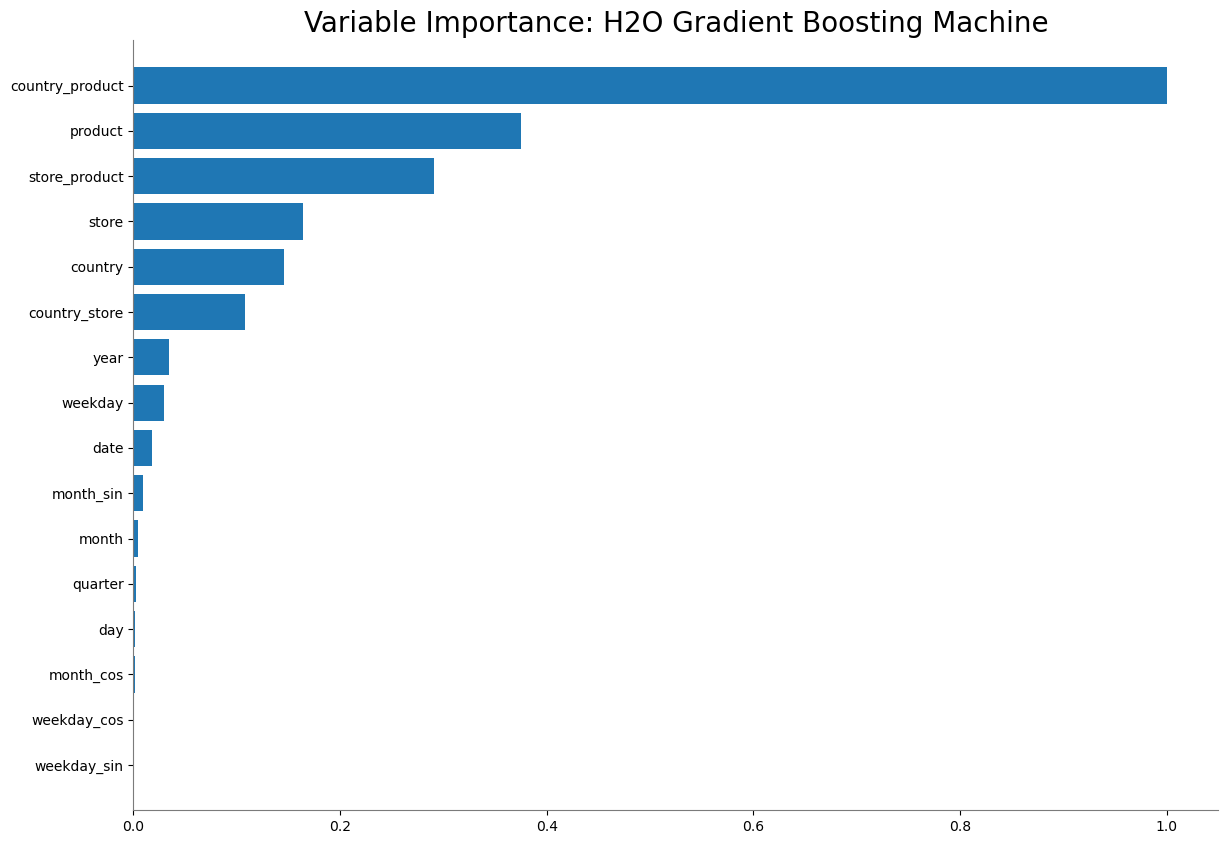

<Figure size 640x480 with 0 Axes>

In [42]:
importance = h2o_gbm.varimp()
h2o_gbm.varimp_plot(num_of_features=20)

## Forecast on Test

In [44]:
pred = h2o_gbm.predict(test_h2o)
predictions_df = pred.as_data_frame()
predictions_df

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict
0,201.574399
1,832.605091
2,679.444956
3,391.242423
4,485.652148
...,...
98545,474.908998
98546,2482.274090
98547,1978.652718
98548,1108.599596


## Save Submission

In [47]:
submission = pd.DataFrame({'id': test.index, 'num_sold': predictions_df['predict']})
submission.to_csv('submission_1.csv', index=False)

In [48]:
submission

,id,num_sold
0,230130,201.574399
1,230131,832.605091
2,230132,679.444956
3,230133,391.242423
4,230134,485.652148
...,...,...
98545,328675,474.908998
98546,328676,2482.274090
98547,328677,1978.652718
98548,328678,1108.599596
